In [1]:
% load_ext autoreload
% autoreload 2


In [2]:
import glob
import os
import pandas as pd
from collections import defaultdict
import datetime
import src.mex_helper as mex
import folium
from src.utils.map_vis import time_slider_choropleth, geojson_per_row

# average over weekday and weekend

In [3]:
call_direction = 'out+in'

In [4]:
%%time
aver = mex.stat_tw_dow_aver_hr_uniq_user(call_direction)

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out+in.pickle
CPU times: user 1.44 s, sys: 20 ms, total: 1.46 s
Wall time: 1.43 s


In [5]:
tw_avg_wd = pd.DataFrame(aver['wd']).T
tw_avg_wk = pd.DataFrame(aver['wk']).T

## difference between use out+in and only out is small

In [4]:
aver_out = mex.stat_tw_dow_aver_hr_uniq_user('out')

loading cached tw average stats/stat_tw_dow_aver_hr_uniq_user-out.pickle
CPU times: user 1.44 s, sys: 40 ms, total: 1.48 s
Wall time: 1.45 s


In [22]:
div = tw_avg_wd/pd.DataFrame(aver_out['wd']).T

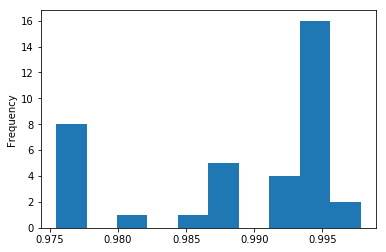

In [33]:
%matplotlib inline
series = pd.Series(div.values.flatten())
series[series<1].plot(kind='hist')

# distribute tower stats to grids

In [6]:
# rkind = 'cities'
# rname='city'
rkind = 'urban_areas_16'
rname='urban'
mex_t2g = mex.tower2grid(rkind, 1000)


reading existing t2g file: data/mex_tower/mex_t2g_urban_areas_16_1000m.csv


In [7]:
print(f'number of towers in {rkind} has no call at all during weekday and weekend')
len(set(mex_t2g.gtid) - set(tw_avg_wd.index)), len(set(mex_t2g.gtid) - set(tw_avg_wk.index)),

number of towers in urban_areas_16 has no call at all during weekday and weekend


(146, 146)

In [8]:
def grid_avgerage(tw_avg, t2g):
    # there are grids without any call throughout the observation period
    g_avg = t2g.merge(tw_avg, left_on='gtid', right_index=True, how='left')

    for h in range(24):
        h=str(h)
        g_avg[h] = g_avg[h] * g_avg['weight']

    g_avg= g_avg.drop(['gtid','weight'], axis=1).groupby('grid').sum()  # fillna=0 by default

    return g_avg

In [9]:
g_avg_wd = grid_avgerage(tw_avg_wd, mex_t2g)
g_avg_wk = grid_avgerage(tw_avg_wk, mex_t2g)

# visualize by hour each city

In [10]:
mex_grids = mex.grids(rkind, 1000)

reading existing grids


In [11]:
fake_dates = [f"1971-01-{i:02}" for i in range(1,25)]

In [12]:
print('rkind:', rkind)
mex_regions = mex.regions(rkind)

rkind: urban_areas_16


## all grids

In [13]:
%%time
print(rkind, rname)
for dow, g_avg in [('wd', g_avg_wd), ('wk',g_avg_wk)]:
    print('day of week:', dow)
    for c in mex_regions.index:
        lon,lat = mex_regions.loc[c].geometry.centroid.coords[0]
        gc = mex_grids[mex_grids[rname]==c]
        gc_avg = g_avg.loc[gc.grid]
        values = gc_avg.T.to_dict('list')
        some_map = folium.Map(location=[lat,lon], zoom_start=10)
        time_slider_choropleth(gc, values, fake_dates, color_per_day=True).add_to(some_map)
        some_map.save(f'maps/MexGridChoropleth-{call_direction}-{rkind}/{c}_{dow}.html')

urban_areas_16 urban
day of week: wd
day of week: wk
CPU times: user 21.3 s, sys: 12 ms, total: 21.3 s
Wall time: 21.3 s


## keep hotspot only

In [14]:
from src.utils import loubar_thres

In [15]:
def keep_hotspot(gc_avg):
    for h in gc_avg:
        arr = gc_avg[h]
        loubar, arr_thres = loubar_thres(arr,is_sorted=False)
        gc_avg[h][gc_avg[h]<=arr_thres]=0
#         print(h, loubar, arr_thres)

In [16]:
%%time
for dow, g_avg in [('wd', g_avg_wd), ('wk',g_avg_wk)]:
    print('day of week:', dow)
    for c in mex_regions.index:
        lon,lat = mex_regions.loc[c].geometry.centroid.coords[0]
        gc = mex_grids[mex_grids[rname]==c]
        gc_avg = g_avg.loc[gc.grid].copy()
        keep_hotspot(gc_avg)
        values = gc_avg.T.to_dict('list')
        some_map = folium.Map(location=[lat,lon], zoom_start=10)
        time_slider_choropleth(gc, values, fake_dates, color_per_day=True).add_to(some_map)
#         break
        some_map.save(f'maps/MexGridChoroplethHotSpot-{call_direction}-{rkind}/{c}_{dow}.html')
#     break

day of week: wd
day of week: wk
CPU times: user 22.6 s, sys: 12 ms, total: 22.6 s
Wall time: 22.6 s


## hotspot persistency

In [17]:
from branca.colormap import linear
cmap = linear.Reds_09.scale(0,24)

In [18]:
%%time
for dow, g_avg in [('wd', g_avg_wd), ('wk',g_avg_wk)]:
    print('day of week:', dow)
    
    some_map = folium.Map(location=[mex.CLAT,mex.CLON], zoom_start=8)
    
    for c in mex_regions.index:
        cgeom=mex_regions.loc[c].geometry
        lon,lat = cgeom.centroid.coords[0]
        gc = mex_grids[mex_grids[rname]==c].copy()
        gc_avg = g_avg.loc[gc.grid].copy()
        keep_hotspot(gc_avg)
        gc['persistency'] = (gc_avg!=0).sum(axis=1)
        gc = gc[gc.persistency!=0]
        gc = gc.append({'grid':-1, 'geometry':cgeom, 'persistency':0},ignore_index=True).sort_values('grid')
        gjson = gc[['grid','persistency','geometry']].to_json()
        folium.GeoJson(
            gjson,
            name=c,
            style_function=lambda feature: {
                'fillColor': cmap(feature['properties']['persistency']),
                'color': 'black',
                'weight': 1,
                'dashArray': '5, 5',
                'fillOpacity': 0.8,
            }
        ).add_to(some_map)
#         break
    
    cmap.caption = 'hotspot persistency (hours)'
    cmap.add_to(some_map)
    folium.LayerControl(collapsed=False).add_to(some_map)
    some_map.save(f'maps/MexGridChoroplethHotSpotPersistency_{dow}-{call_direction}-{rkind}.html')
#     break


day of week: wd
day of week: wk
CPU times: user 5.63 s, sys: 32 ms, total: 5.66 s
Wall time: 5.65 s
